In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Equilibrium mid market price

In [2]:
def exp_decay(start, length, half_life):
    return start * np.exp(-np.log(2)/half_life) ** length

print(exp_decay(10, 1, 1))
print(exp_decay(10, 2, 1))

5.0
2.5


In [3]:
price = [round(i, 1) for i in np.arange(7, 12.1, 0.1)]
bids = list(np.zeros(len(price)))
asks = list(np.zeros(len(price)))

for i, (p, b, a) in enumerate(zip(price, bids, asks)):
    if p == 7: bids[i] = 10000
    if p == 8: bids[i] = 3000
    if p == 9: bids[i] = 4500
    if p == 10: asks[i] = 1000
    if p == 11: asks[i] = 10000
    if p == 12: asks[i] = 2500

d = {
    "price" : price,
    "bids" : bids, 
    "asks" : asks,
}

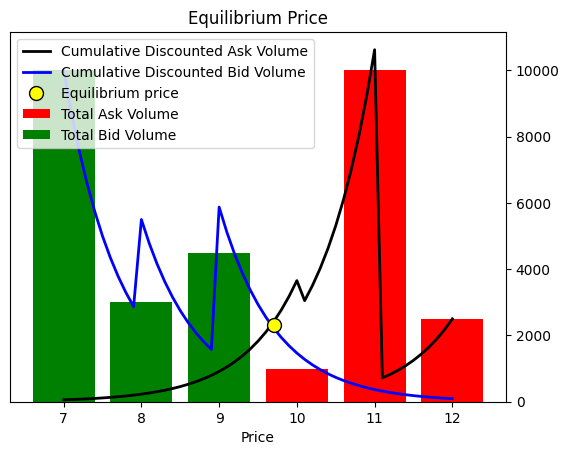

In [5]:
ob = pd.DataFrame(data = d)
delta = 0.1
half_life = 0.5

ob["bids.exp_decay"] = np.nan
ob["asks.exp_decay"] = 2500

for i, row in ob.iterrows():
    if i == 0:
        ob["bids.exp_decay"].iloc[i] = ob["bids"].iloc[i]
    else:
        ob["bids.exp_decay"].iloc[i] = ob["bids"].iloc[i] + exp_decay(ob["bids.exp_decay"].iloc[i-1], delta, half_life)


for i, row in ob[::-1].iterrows():
    if i == len(ob)-1:
        ob["asks.exp_decay"].iloc[i] = ob["asks"].iloc[i]
    else:
        ob["asks.exp_decay"].iloc[i] = ob["asks"].iloc[i] + exp_decay(ob["asks.exp_decay"].iloc[i+1], delta, half_life)

condition = (ob["bids.exp_decay"].shift(1) > ob["asks.exp_decay"].shift(1)) & (ob["bids.exp_decay"] < ob["asks.exp_decay"])
ob["equilibrium_price"] = np.where(condition, (ob["asks.exp_decay"] + ob["bids.exp_decay"])/2, np.nan)


ob.set_index("price", inplace=True)

fig, ax = plt.subplots()
plt.xlabel(f'Price')
ax.yaxis.tick_right()
plt.title('Equilibrium Price')
ax.bar(ob.index, ob["asks"], color="r", label="Total Ask Volume")
ax.bar(ob.index, ob["bids"], color="g", label="Total Bid Volume")
ax.plot(ob["asks.exp_decay"], 'k', linewidth=2, label=f"Cumulative Discounted Ask Volume")
ax.plot(ob["bids.exp_decay"], 'b', linewidth=2, label=f"Cumulative Discounted Bid Volume")
ax.plot(ob["equilibrium_price"], label=f"Equilibrium price", marker="o", markerfacecolor="yellow", markeredgecolor="black", markersize=10, markeredgewidth=1, linewidth=0)
ax.legend()
fig.patch.set_facecolor('xkcd:white')
# fig.set_size_inches(20,10)